In [1]:
import math
import matplotlib.pyplot as plt
plt.rcParams.update({"mathtext.default": "regular"})
from tqdm.auto import tqdm

from dolfinx import default_scalar_type
from dolfinx.fem import (Expression, Function, functionspace,
                         assemble_scalar, dirichletbc, form, locate_dofs_topological)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.mesh import create_rectangle, locate_entities_boundary

from mpi4py import MPI
from ufl import SpatialCoordinate, TestFunction, TrialFunction, div, dot, dx, grad, inner

import ufl
import numpy as np

Реализуем функцию `solve_poisson`, которая будет искать решения задачи Дирихле для уравнения Пуассона на квадрате $[0,\pi]\times[0,\pi]$ вида $u(x,y)=\sin{ax}\cos{by}$ методом конечных элементов.

In [2]:
def get_u_true(module, a, b):
    def u_true(x):
        return module.sin(a * x[0]) * module.cos(b * x[1])
    return u_true

In [3]:
def solve_poisson(a, b, N=10):
    u_true_np = get_u_true(np, a, b)
    u_true_ufl = get_u_true(ufl, a, b)
    
    domain = create_rectangle(
        MPI.COMM_WORLD,
        ((0., 0.), (np.pi, np.pi)),
        (N, N),
    )
    V = functionspace(domain, ("CG", 1))

    u = TrialFunction(V)
    v = TestFunction(V)

    x = SpatialCoordinate(domain)
    f = -div(grad(u_true_ufl(x)))

    a = inner(grad(u), grad(v)) * dx
    L = f * v * dx

    u_bc = Function(V)
    u_bc.interpolate(u_true_np)
    facets = locate_entities_boundary(domain, domain.topology.dim - 1, lambda x: np.full(x.shape[1], True))
    dofs = locate_dofs_topological(V, domain.topology.dim - 1, facets)
    bcs = [dirichletbc(u_bc, dofs)]

    problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    return domain, problem.solve(), u_true_ufl(x)

Далее напишем функции, которые будут вычислять погрешность решения в нормах $L_2$, $C$ и $H^1$ соответственно.

In [4]:
def get_l2_error(uh, u_ex):
    comm = uh.function_space.mesh.comm
    error = form((uh-u_ex)**2 * ufl.dx)
    E = np.sqrt(comm.allreduce(assemble_scalar(error), MPI.SUM))
    if comm.rank == 0:
        return E

In [5]:
def get_c_error(uh, u_ex):
    comm = uh.function_space.mesh.comm
    u_ex_V = Function(uh.function_space)
    if isinstance(u_ex, ufl.core.expr.Expr):
        u_expr = Expression(u_ex, uh.function_space.element.interpolation_points())
        u_ex_V.interpolate(u_expr)
    else:
        u_ex_V.interpolate(u_ex)
    E_local = np.max(np.abs(uh.x.array - u_ex_V.x.array))
    E = comm.allreduce(E_local, MPI.MAX)
    if comm.rank == 0:
        return E

In [6]:
def get_h1_error(uh, u_ex):
    comm = uh.function_space.mesh.comm
    error = form(((uh-u_ex)**2 + dot(grad(uh-u_ex), grad(uh-u_ex))) * ufl.dx)
    E = np.sqrt(comm.allreduce(assemble_scalar(error), MPI.SUM))
    if comm.rank == 0:
        return E

In [7]:
def interpolate_u_true(u_true, uh):
    comm = uh.function_space.mesh.comm
    u_ex_V = Function(uh.function_space)
    if isinstance(u_ex, ufl.core.expr.Expr):
        u_expr = Expression(u_ex, uh.function_space.element.interpolation_points())
        u_ex_V.interpolate(u_expr)
    else:
        u_ex_V.interpolate(u_ex)
    return u_ex_V

Найдём численное решение задачи для трёх случаев - низкие частоты, высокие частоты и промежуточные.

In [8]:
results = {}
N_params = np.arange(10, 500+1, 10)
for a, b in [(1, 1), (2, 7), (14, 14)]:
    print("\n\n============================================")
    print(f"Training model for u(x,y)=sin({a}x)*cos({b}y)")

    solution_repr = r"$u(x,y)=\sin{" + str(a) + r"x}\cdot\cos{" + str(b) + "y}$"

    h_steps = []
    l2_metrics = []
    c_metrics = []
    h1_metrics = []
    for N in tqdm(N_params):
        h = 1. / N
        msh, uh, u_ex = solve_poisson(a, b, N)
        h_steps.append(h)
        l2_metrics.append(get_l2_error(uh, u_ex))
        c_metrics.append(get_c_error(uh, u_ex))
        h1_metrics.append(get_h1_error(uh, u_ex))

    results[(a, b)] = {
        "solution": interpolate_u_true(u_ex, uh),
        "solution_repr": solution_repr,
        "h": h_steps,
        "uh": uh,
        "l2_metrics": l2_metrics,
        "c_metrics": c_metrics,
        "h1_metrics": h1_metrics,
    }



Training model for u(x,y)=sin(1x)*cos(1y)


  0%|          | 0/50 [00:00<?, ?it/s]



Training model for u(x,y)=sin(2x)*cos(7y)


  0%|          | 0/50 [00:00<?, ?it/s]



Training model for u(x,y)=sin(14x)*cos(14y)


  0%|          | 0/50 [00:00<?, ?it/s]

Для каждой функции изобразим точное, численное решения, модуль их разности, а также зависимость норм погрешности от шага разбиения $h$.

In [9]:
def get_values_to_plot(uh):
    X = uh.function_space.mesh.geometry.x[:, 0]
    Y = uh.function_space.mesh.geometry.x[:, 1]
    coords = np.vstack([X, Y, uh.x.array]).T.tolist()
    coords = sorted(map(lambda x: tuple(x), coords))
    values = np.array(list(map(lambda x: x[2], coords)))
    return values.reshape(np.unique(X).shape[0], -1)

In [10]:
cmap="gist_rainbow_r"
beautiful_labels = [r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$"]

def plot_model(model_cfg):
    solution, solution_repr, uh, h, l2_metr, c_metr, h1_metr = (
        model_cfg[attr] for attr in (
            "solution", "solution_repr", "uh", "h",
            "l2_metrics", "c_metrics", "h1_metrics"
        )
    )

    u_pred = get_values_to_plot(uh)
    u_true = get_values_to_plot(solution)

    N = u_true.shape[0]

    fig, ax = plt.subplots(2, 3, figsize=(10, 6), constrained_layout=True)
    fig.suptitle(solution_repr, fontsize=16)

    ax[0, 0].imshow(np.rot90(u_true), cmap=cmap)
    ax[0, 0].set_title("$u(x,y)$")

    im_01 = ax[0, 1].imshow(np.rot90(u_pred), cmap=cmap)
    ax[0, 1].set_title("$model(x,y)$")

    im_02 = ax[0, 2].imshow(np.rot90(np.abs(u_true - u_pred)), cmap=cmap)
    ax[0, 2].set_title("$| u(x,y)-model(x,y)|$")

    ax[1, 0].set_title(r"$\| u-model \|_{L_2}(h)$")
    ax[1, 0].plot(h[::-1], l2_metr[::-1])

    ax[1, 1].set_title(r"$\| u-model \|_{C}(h)$")
    ax[1, 1].plot(h[::-1], l2_metr[::-1])

    ax[1, 2].set_title(r"$\| u-model \|_{H^1}(h)$")
    ax[1, 2].plot(h[::-1], l2_metr[::-1])

    for i in range(3):
        ax[0, i].set_xticks(np.linspace(0, N, len(beautiful_labels)))
        ax[0, i].set_xticklabels(beautiful_labels)
        ax[0, i].set_xlabel("$x$")

        ax[0, i].set_yticks(np.linspace(0, N, len(beautiful_labels)))
        ax[0, i].set_yticklabels(beautiful_labels[::-1])
        ax[0, i].set_ylabel("$y$")

        ax[1, i].set_xlabel("$h$")
        ax[1, i].set_yscale("log")
        ax[1, i].grid(True)        
    
    cbar_u = plt.colorbar(im_01, ax=(ax[0, 0], ax[0, 1]), shrink=0.8)
    cbar_d = plt.colorbar(im_02, ax=ax[0, 2], shrink=0.8)
    
    for cbar in (cbar_u, cbar_d):
        cbar.formatter.set_powerlimits((0, 0))
        cbar.formatter.set_useMathText(True)
    
    plt.show()

In [11]:
def plot_loss_cmp(model_cfg):
    h, L2, C, H1 = (model_cfg[x][::-1] for x in ("h", "l2_metrics", "c_metrics", "h1_metrics"))
    fig, ax = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)
    fig.suptitle("Зависимость погрешности решения в разных нормах от шага разбиения $h$", fontsize=16)
    ax.plot(h, L2, label="$L_2$")
    ax.plot(h, C, label="$C$")
    ax.plot(h, H1, label="$H^1$")
    ax.set_xlabel("Шаг разбиения  $h$")
    ax.set_ylabel("Норма погрешости")
    ax.set_yscale("log")
    ax.grid(True)
    plt.legend(loc="lower right")
    plt.show()

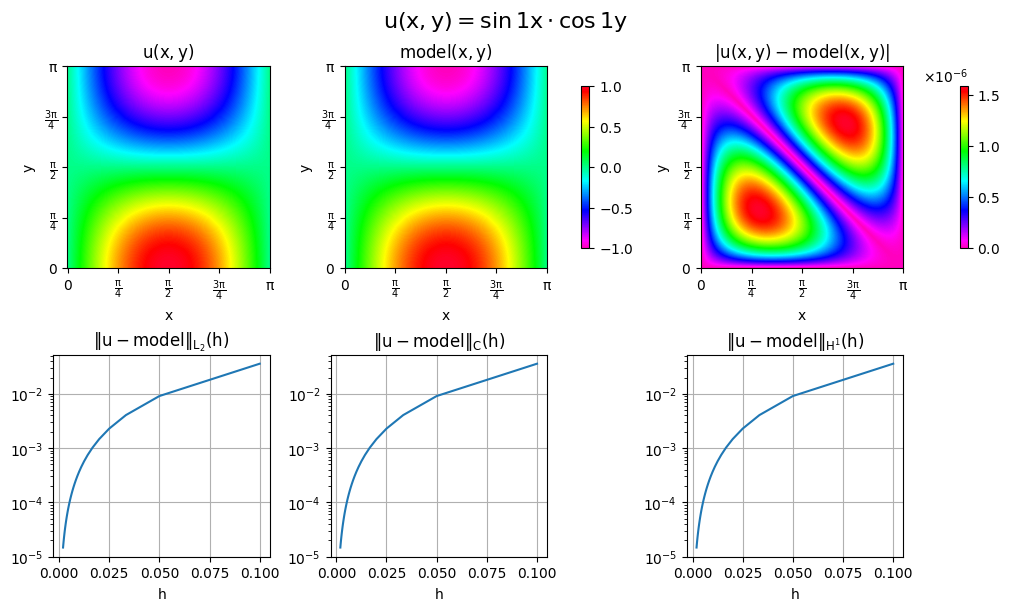

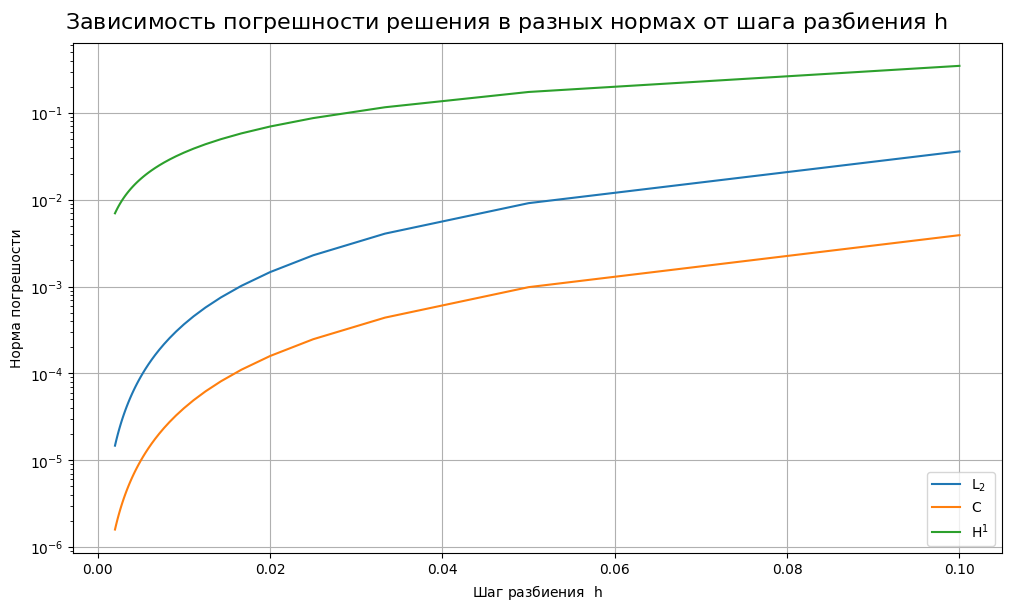

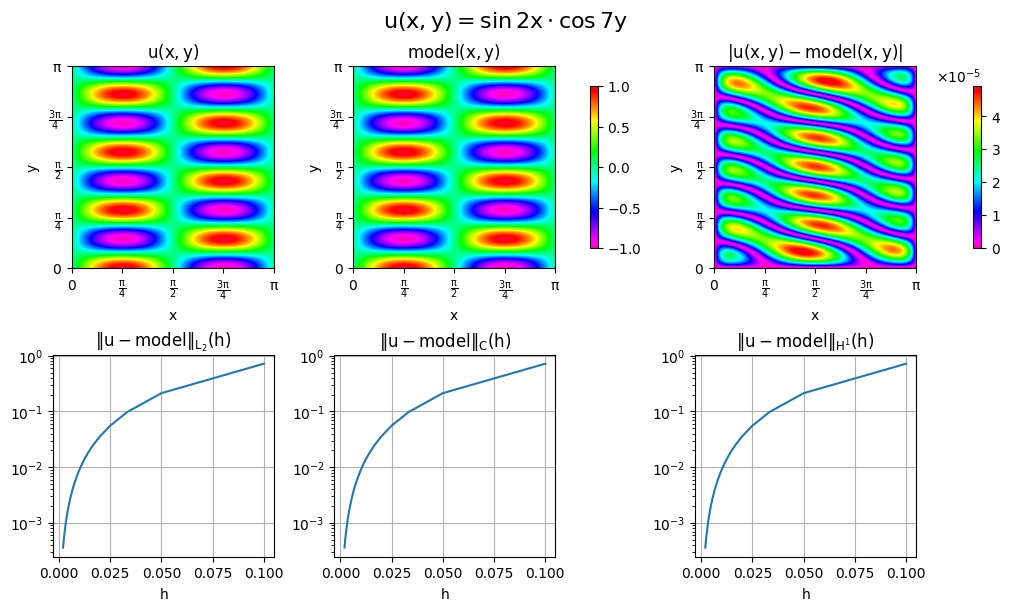

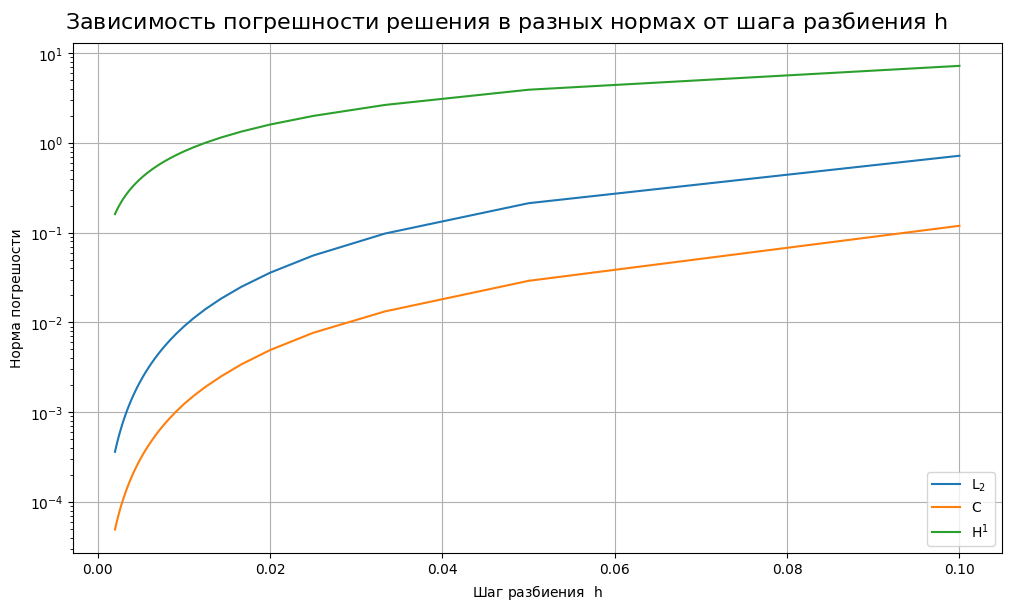

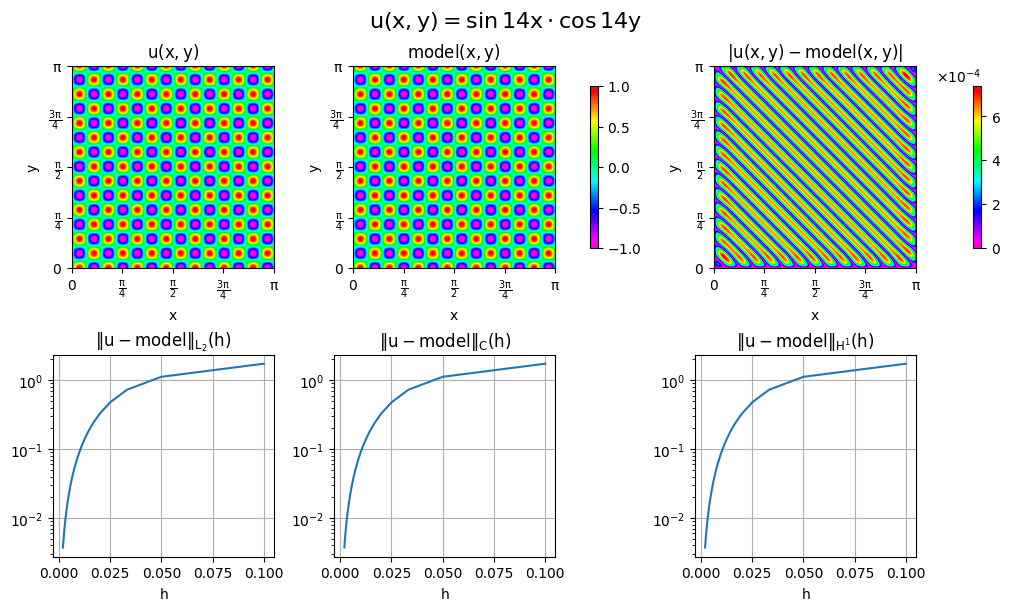

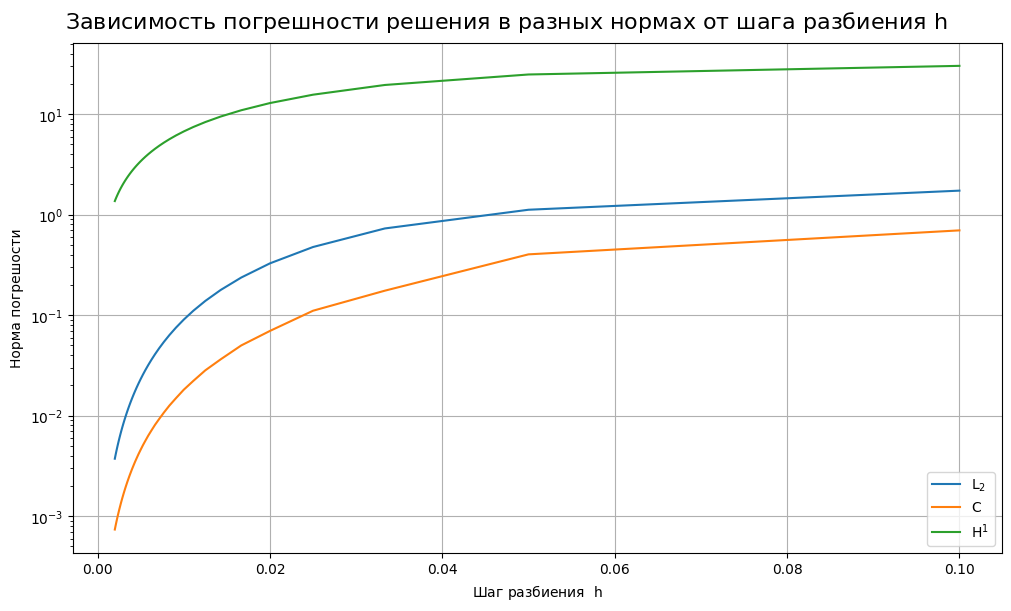

In [12]:
for frequencies in [(1, 1), (2, 7), (14, 14)]:
    plot_model(results[frequencies])
    plot_loss_cmp(results[frequencies])